In [1]:
import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
class SubLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
class Discriminator(nn.Module):
    def __init__(self,in_channel=3):
        super().__init__()
        self.structure=nn.Sequential(
            nn.Conv2d(in_channel,64,kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),
            #SubLayer(in_channel,64,stride=1),
            SubLayer(64,128,stride=2),
            SubLayer(128,256,stride=2),
            SubLayer(256,512,stride=1),
            nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect")
        )
    def forward(self,x):
        x=self.structure(x)
        x=torch.sigmoid(x)
        return x

summary(Discriminator(),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
          SubLayer-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
         SubLayer-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
         SubLayer-14          [-1, 512,

* The disciminator follows the structure of a PatchGAN containing 3 sublayers (Conv2d, InstanceNorm2d and ReLU) to learn the patch features of the images by extending the channels number through each convolutional layer.
* The output is a (30 by 30) patch matrix containing normalized features (Sigmoid()) of the input batch.

# Generator

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )
    def forward(self, x):
        return self.conv(x)
class ResidualLayer(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvLayer(channels, channels, kernel_size=3, padding=1),
            ConvLayer(channels, channels, use_act=False, kernel_size=3, padding=1),
        )
    def forward(self, x):
        return x + self.block(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, img_channels=3, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.Sequential(
            ConvLayer(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
            ConvLayer(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
        )
        self.res_blocks = nn.Sequential(
            *[ResidualLayer(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.Sequential(
            ConvLayer(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvLayer(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        x = self.down_blocks(x)
        x = self.res_blocks(x)
        x = self.up_blocks(x)
        x = torch.tanh(self.last(x))
        return x

torch.Size([2, 3, 256, 256])


In [10]:
summary(Generator(),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-2         [-1, 64, 256, 256]               0
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-5        [-1, 128, 128, 128]               0
              ReLU-6        [-1, 128, 128, 128]               0
         ConvLayer-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
        ConvLayer-11          [-1, 256, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

* The generator is a CycleGAN structure composed of 3 stages initialized by an encoder to implement a 3-time convolutional decomposition to result in activated values with a 4-th times division size before being transferred in a 6-residual blocks structure with unchanged parameters for transformation and eventually finalized by a decoder which enlarges the residual size back into the original shape in RGB scale of the image by 2 convolution-transpose layers.

# DataLoading

In [6]:
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()

In [9]:
device

device(type='cpu')

In [10]:
image_size = 256
batch_size = 8 #number of image for each trainning
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean
DIR_NE='C:/Users/Pro/Desktop/Grp_Project/URGENT!/jaffe/NE_train'
#input and load the Neutral expression
folder_NE = ImageFolder(DIR_NE, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
train_NE = DataLoader(folder_NE, batch_size, shuffle=True, num_workers=4)#, pin_memory=True)

DIR_HA='C:/Users/Pro/Desktop/Grp_Project/URGENT!/jaffe/HA_train'
folder_HA = ImageFolder(DIR_HA, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
train_HA = DataLoader(folder_HA, batch_size, shuffle=True, num_workers=4)#, pin_memory=True)
#input and load the Neutral expression

In [11]:
#data_loader = DeviceDataLoader(train_All, device)
disc_HA = to_device(Discriminator(), device)#real or fake Happy face
disc_NE = to_device(Discriminator(), device)#real or fake Neutral face
gen_HA = to_device(Generator(), device)#generate fake Happy face
gen_NE = to_device(Generator(), device)#generate fake Neutral face

As described in the report, there are 2 discriminators and 2 generators defined to generate and differentiate images in both class distribtions

In [12]:
NE_loader = DeviceDataLoader(train_NE,device)
HA_loader =DeviceDataLoader(train_HA,device)

In [13]:
import torch.optim as optim
opt_disc = optim.Adam(list(disc_HA.parameters())+list(disc_NE.parameters()), lr=2e-5,betas=(0.5,0.999))#momentum & beta2
opt_gen = optim.Adam(list(gen_NE.parameters())+list(gen_HA.parameters()), lr=2e-5,betas=(0.5,0.999))

Adam is taken as the optimizers for both discriminators and generators. In particular, it considers the parameters combination in discriminators and generators for both distribtions.

In [14]:
#g_scaler = torch.cpu.amp.GradScaler()
#d_scaler = torch.cpu.amp.GradScaler()

In [15]:
l1=nn.L1Loss()#MAE (mean absolute error) criteration for consistent cycle loss 
mse=nn.MSELoss()#MSE (mean square error) criteration for adversarial loss

In [16]:
lambda_cycle=10#coefficient of importance for consistent cycle loss 
from torchvision.utils import save_image

In [17]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

# Training

In [21]:
num_epochs = 10
Dloss_stored=[]
for epoch in range(num_epochs):
    for i, ((NE,lc),(HA,lH)) in enumerate(zip(NE_loader,HA_loader)):
        #consider batches (1 by 1 image) from zipped dataloader
        fake_HA =gen_HA(NE)#generate fake HA from an input NE
        D_HA_real =disc_H(HA)#guess of discriminator for a real HA
        D_HA_fake =disc_H(fake_HA.detach())#not repeat the first line while training gen
        #guess the fake probability of the fake HA generated by a NE
        #H_reals += D_H_real.mean().item()
        D_HA_real_loss = mse(D_HA_real,torch.ones_like(D_HA_real))#attach the correct real label for the real guess
        #and consider the MSE between these labels
        D_HA_fake_loss = mse(D_HA_fake,torch.zeros_like(D_HA_fake))#attach the correct fake label for the fake guess 
        D_HA_loss =D_HA_real_loss+D_HA_fake_loss
        ##disciminator loss to distinguish HA ability is the summation of fake and real cases
        
        #the same procedure is applied for the reverse mapping side of the discriminator to classify NE 
        fake_NE = gen_NE(HA)
        D_NE_real =disc_NE(NE)
        D_NE_fake =disc_NE(fake_cow.detach())#not repeat the first line while training gen
        D_NE_real_loss = mse(D_NE_real,torch.ones_like(D_NE_real))
        D_NE_fake_loss = mse(D_NE_fake,torch.zeros_like(D_NE_fake))
        D_NE_loss =D_NE_real_loss+D_NE_fake_loss
        #All D Loss is the average value of disciminator losses of NE and HA
        #these discriminators encourage the ability 
        #to generate a style image for a distribution from the opposite class
        #All D Loss"
        D_loss=(D_HA_loss+D_NE_loss)/2
            
        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()
        #the general D_loss is optimized and updated step by step
        
        D_HA_fake = disc_HA(fake_HA)
        D_NE_fake = disc_NE(fake_NE)
        loss_G_HA = mse(D_HA_fake,torch.ones_like(D_HA_fake))
        #attach the wrong real label for the fake guess to fool the discriminator
        loss_G_NE = mse(D_NE_fake,torch.ones_like(D_NE_fake))
        #attach the wrong fake label for the real guess
        #cycle loss
        cycle_NE =gen_C(fake_HA)
        #the NE image reconstructed from fakely generated HA from a NE 
        cycle_HA=gen_H(fake_NE)
        #the horse image reconstructed from fakely generated NE from a HA
        cycle_NE_loss= l1(NE,cycle_NE)
        cycle_HA_loss=l1(HA,cycle_HA)
        ##cycle consistent loss of horse is the MAE between the reconstructed horse and its original form
        #this is conducted to make the generators gen_C and gen_H able to synthesize the same shape of the animal  
        #identiy loss
        #all-in Loss
        G_loss=(loss_G_NE+loss_G_HA+cycle_NE_loss*lambda_cycle+cycle_HA_loss*lambda_cycle)
        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()
        #all of these losses are combined and trained iteratively by Adam optimizer
        
    if epoch%2==0:
        save_image(fake_HA*0.5+0.5,f"savedHA_{epoch+10}.png")
        save_image(fake_NE*0.5+0.5,f"savedNE_{epoch+10}.png")
        

In [36]:
PATH1 = 'Generater_Horse.pt'
torch.save(gen_H, PATH1)

PATH2 = 'Generator_Cow.pt'
torch.save(gen_C, PATH2)


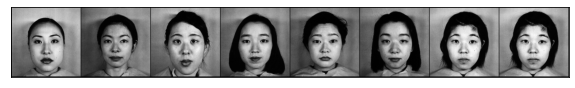

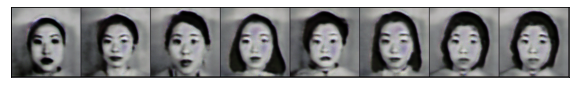

In [22]:
for i, (NE,lc) in enumerate(train_NE):
    if i==1:
        th=NE
        show_images(th)
        show_images(gen_HA(th))
# use the trained generator of Happy expression to generate happy faces from Neural input faces 
#but the model show a poor performance of only the same Neutral faces as the reconstruction

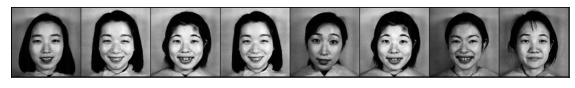

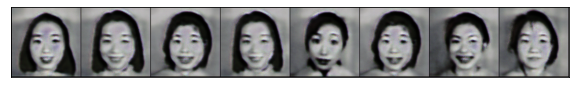

In [24]:
#gencow=torch.load('Generator_Cow.pt')
for i, (HA,lc) in enumerate(train_HA):
    if i==1:
        th=HA
        show_images(th)
        show_images(gen_NE(th))

In [15]:
len(train_All)

82